<center><h1> Text Classification (Sentiment Analysis) </h1></center>

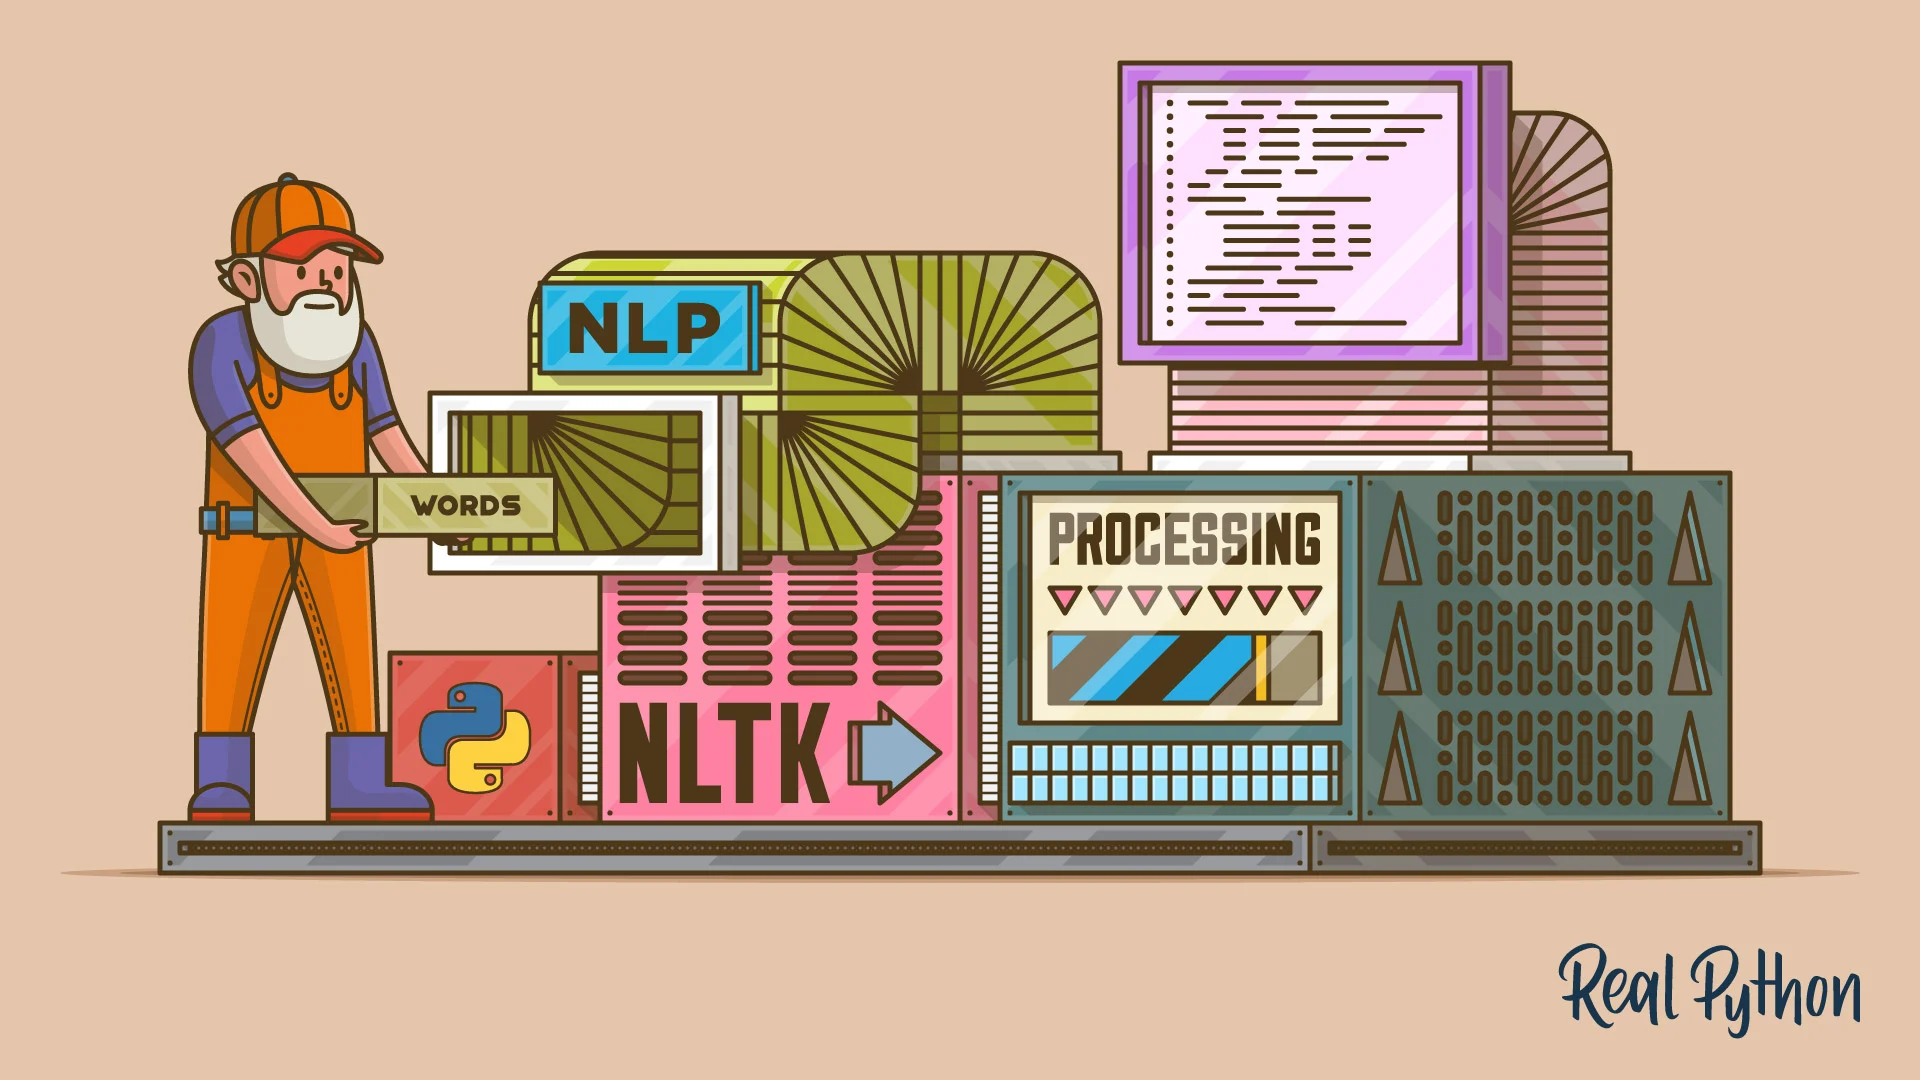

The attempt will be to perform a sentiment analysis using Keras and Python.

In [1]:
import string
import pandas as pd
import numpy as np
import glob

In [2]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.text import text_to_word_sequence
from keras.utils import pad_sequences
from keras.layers import Embedding
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import Conv1D
from keras.layers import MaxPooling1D
from keras.layers import LSTM
from keras.callbacks import EarlyStopping

In [3]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\82102\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Data Pre-processing

Key Aspects:
- Binary Encoding (<b>y = 1</b> for positive | <b>y = 0</b> for negative)
- Punctuations and numbers will be removed

<br>
We will aggregate all the individual text files to build lists for positive and negative sentiments.

In [4]:
pos_files = glob.glob('../data/pos/*.txt')
neg_files = glob.glob('../data/neg/*.txt')

pos_document = []
neg_document = []

for file in pos_files:
    with open(file, 'r') as f:
        pos_document.append(f.read())
            
for file in neg_files:
    with open(file, 'r') as f:
        neg_document.append(f.read())

In [5]:
len(pos_document)

1000

In [6]:
len(neg_document)

1000

In [7]:
pos_document[0][0:200]

"films adapted from comic books have had plenty of success , whether they're about superheroes ( batman , superman , spawn ) , or geared toward kids ( casper ) or the arthouse crowd ( ghost world ) , b"

#### def remove_extra(docu):

This function will process the data into an appropriate form for the model to intake. <br>
To be precise, we will perform several operations:

- Removes punctuations
- Removes numeric values

In [8]:
def remove_extra(docu):
    # in case we should remove stop words
    #stop_words = set(stopwords.words('english'))
    for i in range(0,len(docu),1):
        temp_seq = text_to_word_sequence(docu[i])
        for k in range(0,len(temp_seq),1):
            temp_seq[k] = temp_seq[k].translate(str.maketrans('', '', string.punctuation))
        temp_index = []
        for L in range(0,len(temp_seq),1):
            for character in temp_seq[L]:
                if character.isdigit():
                    temp_index.append(L)
                    break

        counter = 0
        for index in temp_index:
            del temp_seq[index - counter]
            counter += 1
        temp = " ".join(temp_seq)
        docu[i] = temp
        
    return docu

In [9]:
filtered_pos = remove_extra(pos_document)
filtered_neg = remove_extra(neg_document)
filtered_total = filtered_pos + filtered_neg

In [10]:
len(filtered_total)

2000

### Before and After

In [11]:
pos_document[0][0:200]

'films adapted from comic books have had plenty of success whether theyre about superheroes batman superman spawn or geared toward kids casper or the arthouse crowd ghost world but theres never really '

In [12]:
filtered_pos[0][0:200]

'films adapted from comic books have had plenty of success whether theyre about superheroes batman superman spawn or geared toward kids casper or the arthouse crowd ghost world but theres never really '

## EDA

### Unique Word Count

#### def count_unique_words(doc_1, doc_2):

Counts the unique number of words from both positive and negative documents.
<br><br>
We have <b>40,989</b> unique words in our data.

In [13]:
def count_unique_words(doc_1, doc_2):
    total_word_set = set()
    for i in [pos_document,neg_document]:
        for j in range(0,len(i),1):
            temp_seq = text_to_word_sequence(i[j])
            for k in temp_seq:
                total_word_set.add(k)
                
    return total_word_set, len(total_word_set)

In [14]:
unique_word, unique_word_count = count_unique_words(filtered_pos, filtered_neg)

In [15]:
count = 10
for i in unique_word:
    if count > 0:
        print(i)
        count-=1

bateman
roxbury
geeky
constant
potboiler
frights
followers
yorkers
corleone
lingerie


In [16]:
unique_word_count

40989

### Statistics

#### def word_stat(doc_1, doc_2):

This function returns the mean number of words amongst all texts. <br>
Also, it returns the standard deviation <br><br>
For our data:
- Mean : <b>651.1725 words</b>
- Std : <b>287.516117 words</b>

In [17]:
def word_stat(doc_1, doc_2):
    count_word_list = []
    for i in [doc_1,doc_2]:
        for j in range(0,1000,1):
            temp_seq = text_to_word_sequence(i[j])
            count_word_list.append(len(temp_seq))

    df_count = pd.DataFrame(count_word_list)
    df_count.columns = ["Review Length"]
    return df_count

In [18]:
word_count = word_stat(filtered_pos, filtered_neg)

In [19]:
word_count.mean()

Review Length    651.1725
dtype: float64

In [20]:
word_count.std()

Review Length    287.516117
dtype: float64

### Graph

ax = word_count.plot(kind='hist', bins=200,figsize=(16,9))
ax.set_xlabel('Review Length')
ax.set_ylabel('Frequency')

## Tokenization

While our text data is superb on its own, it is not convenient for our models to intake the data at its raw form. <br>
Therefore, we will perform tokenization, which in essence, is making a rule where each words get represented by a corresponding and unique numeric values. <br><br>
One thing to consider, however, is how to construct this rule. <br>
For this case, we will start with the most commonly occurring word to be labeled as 1. <br><br>
Also, we will be splitting our data into train and test data. <br>
There are 1,000 documents for each positive and negative sentinments. <br>
We will be using the first 700 documents from both positive and negative sentiments for our training data and the remaining 300 for testing data.

In [21]:
t = Tokenizer()
t.fit_on_texts(filtered_total)
total_token = t.texts_to_sequences(filtered_total)

In [22]:
train = t.texts_to_sequences((filtered_total[0:700] + filtered_total[1000:1700]))
test = t.texts_to_sequences((filtered_total[700:1000] + filtered_total[1700:]))

In [23]:
train[0][0:15]

[67, 2779, 29, 356, 1651, 32, 93, 1062, 4, 646, 643, 329, 41, 7750, 720]

### 70%

We will determine a review length where 70% of the data lies within. <br>
Using this value, we will truncate our data, meaning that any texts that exceed our length will not be considered in our model.
<br><br> In our case, the review length for the 70% is <b>743. 

In [24]:
word_count.quantile(0.7)

Review Length    743.0
Name: 0.7, dtype: float64

### Truncate / Padding 
I will use <b>Post</b> Truncating and <b>Pre</b> Padding. <br>
The reason I chose pre-padding is that the model would have enough time and data point to caliberate even after seeing numerous 0s. If we post-padded it, then the model would not have had enough time and data to fully caliberate. <br><br>
Also, we will not be using words that don't occur frequently enough. <br>
Therefore, any values that exceed 5,000 will not be used.

In [25]:
padded_total = pad_sequences(total_token, maxlen = 743, truncating = 'post', padding='pre')
padded_fixed = np.copy(padded_total)

In [26]:
for i in range(0,len(padded_fixed),1):
    for j in range(0, len(padded_fixed[i]),1):
        if padded_fixed[i][j] > 5000:
            padded_fixed[i][j] = 0

### Train and Test Data Formation

In [27]:
train_data = np.concatenate((padded_fixed[0:700], padded_fixed[1000:1700]), axis=0)
test_data = np.concatenate((padded_fixed[700:1000], padded_fixed[1700:]), axis=0)

In [28]:
train_label = np.array([1 for i in range(0,700,1)] + [0 for j in range(0,700,1)]).reshape((-1,1))
test_label = np.array([1 for i in range(0,300,1)] + [0 for j in range(0,300,1)]).reshape((-1,1))

## Word Embeddings and its layers

In [29]:
e = Embedding(5001, 32, input_length = 743)
# input_length of 743 is L that results in 70% of the data
# Chosee 5001 for the first parameter to make a model off of top 5000 words.

In [30]:
flat = Flatten()

## Multi-Layer Perceptron

In [31]:
model = Sequential()
model.add(e)
model.add(flat)
model.add(Dense(50, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(50, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(50, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

In [32]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [33]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 743, 32)           160032    
                                                                 
 flatten (Flatten)           (None, 23776)             0         
                                                                 
 dense (Dense)               (None, 50)                1188850   
                                                                 
 dropout (Dropout)           (None, 50)                0         
                                                                 
 dense_1 (Dense)             (None, 50)                2550      
                                                                 
 dropout_1 (Dropout)         (None, 50)                0         
                                                                 
 dense_2 (Dense)             (None, 50)                2

### Train and Test Data Accuracy

#### Model Fitting

In [34]:
model.fit(train_data, train_label, epochs=2, batch_size = 10, verbose=1)

Epoch 1/2
140/140 [==============================] - 5s 32ms/step - loss: 0.6966 - accuracy: 0.5243
Epoch 2/2
140/140 [==============================] - 4s 25ms/step - loss: 0.6606 - accuracy: 0.5964


#### Train Data Accuracy

In [35]:
model.evaluate(train_data, train_label)

44/44 [==============================] - 1s 14ms/step - loss: 0.4500 - accuracy: 0.8536


[0.4500097334384918, 0.8535714149475098]

#### Test Data Accuracy

In [36]:
model.evaluate(test_data, test_label)

19/19 [==============================] - 0s 16ms/step - loss: 0.6993 - accuracy: 0.5417


[0.6992648243904114, 0.5416666865348816]

### Overall

- Train Data: loss of 0.4500 and accuracy of 0.8536
- Test Data: loss of 0.6993 and accuracy of 0.5417

## One-Dimensional Convolutional Neural Network:

In [37]:
model_2 = Sequential()
model_2.add(e)
model_2.add(Conv1D(32,3))
model_2.add(MaxPooling1D(pool_size = 2, strides = 2))
model_2.add(flat)
model_2.add(Dense(50, activation='relu'))
model_2.add(Dropout(0.2))
model_2.add(Dense(50, activation='relu'))
model_2.add(Dropout(0.5))
model_2.add(Dense(50, activation='relu'))
model_2.add(Dropout(0.5))
model_2.add(Dense(1, activation='sigmoid'))

In [38]:
model_2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [39]:
model_2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 743, 32)           160032    
                                                                 
 conv1d (Conv1D)             (None, 741, 32)           3104      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 370, 32)          0         
 )                                                               
                                                                 
 flatten (Flatten)           multiple                  0         
                                                                 
 dense_4 (Dense)             (None, 50)                592050    
                                                                 
 dropout_3 (Dropout)         (None, 50)                0         
                                                      

### Train and Test Data Accuracy

#### Model Fitting

In [40]:
model_2.fit(train_data, train_label, epochs=2, batch_size = 10, verbose=1)

Epoch 1/2
140/140 [==============================] - 4s 26ms/step - loss: 0.6969 - accuracy: 0.5200
Epoch 2/2
140/140 [==============================] - 4s 27ms/step - loss: 0.5777 - accuracy: 0.6743


#### Train Data Accuracy

In [41]:
model.evaluate(train_data, train_label)

44/44 [==============================] - 1s 18ms/step - loss: 0.4288 - accuracy: 0.8350


[0.42879486083984375, 0.8349999785423279]

#### Test Data Accuracy

In [42]:
model.evaluate(test_data, test_label)

19/19 [==============================] - 0s 19ms/step - loss: 0.6605 - accuracy: 0.5617


[0.6605067849159241, 0.5616666674613953]

### Overall

- Train Data: loss of 0.4288 and accuracy of 0.8350
- Test Data: loss of 0.6605 and accuracy of 0.5617

## Long Short-Term Memory Recurrent Neural Network:

In [47]:
es = EarlyStopping(monitor='loss', mode='min', verbose=1, patience = 1)
# Early Stopping

In addition, we will implement Early Stopping for this model.

In [43]:
lstm_model = Sequential()
lstm_model.add(e)
lstm_model.add(LSTM(units=32))
lstm_model.add(Dropout(0.2))
lstm_model.add(Dense(256, activation='relu'))
lstm_model.add(Dropout(0.2))
lstm_model.add(Dense(1, activation='sigmoid'))

In [44]:
lstm_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [45]:
lstm_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 743, 32)           160032    
                                                                 
 lstm (LSTM)                 (None, 32)                8320      
                                                                 
 dropout_6 (Dropout)         (None, 32)                0         
                                                                 
 dense_8 (Dense)             (None, 256)               8448      
                                                                 
 dropout_7 (Dropout)         (None, 256)               0         
                                                                 
 dense_9 (Dense)             (None, 1)                 257       
                                                                 
Total params: 177,057
Trainable params: 177,057
Non-tr

### Train and Test Data Accuracy

#### Model Fitting

In [48]:
lstm_model.fit(train_data, train_label, epochs=50, batch_size = 10, verbose=1, callbacks = es)

Epoch 1/50
140/140 [==============================] - 19s 121ms/step - loss: 0.6096 - accuracy: 0.6993
Epoch 2/50
140/140 [==============================] - 17s 119ms/step - loss: 0.3296 - accuracy: 0.8900
Epoch 3/50
140/140 [==============================] - 17s 119ms/step - loss: 0.1956 - accuracy: 0.9314
Epoch 4/50
140/140 [==============================] - 19s 134ms/step - loss: 0.1128 - accuracy: 0.9643
Epoch 5/50
140/140 [==============================] - 19s 137ms/step - loss: 0.0406 - accuracy: 0.9879
Epoch 6/50
140/140 [==============================] - 20s 142ms/step - loss: 0.0145 - accuracy: 0.9971
Epoch 7/50
140/140 [==============================] - 20s 141ms/step - loss: 0.0152 - accuracy: 0.9950
Epoch 7: early stopping


#### Train Data Accuracy

In [49]:
lstm_model.evaluate(train_data, train_label)

44/44 [==============================] - 3s 53ms/step - loss: 0.0012 - accuracy: 1.0000


[0.0011981187853962183, 1.0]

#### Test Data Accuracy

In [50]:
lstm_model.evaluate(test_data, test_label)

19/19 [==============================] - 1s 52ms/step - loss: 1.0798 - accuracy: 0.7967


[1.0797923803329468, 0.79666668176651]

### Overall

- Train Data: loss of 0.0012 and accuracy of 1.0000
- Test Data: loss of 1.0798 and accuracy of 0.7967

## Conclusion

The LSTM model has outperformed One Dimensional Convolutional Neural Network (CNN) and Multi-layer Perceptron. <br>
There are definitely rooms for improvements. <br>
Due to my computer spec, I couldn't run these operations multiple times to fine-tune the parameters. <br>
Moreover, there may be a better model set-up. <br>
While an accuracy of 0.7967 isn't the optimal result we can obtain, it is still relatively a strong model.